In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import seaborn as sns

# Задача сегментации. Загрузка и просмотр данных

In [2]:
segment_directory = "segmentation.csv"

segment = pd.read_csv(segment_directory, header=0)

По традиции, начну с просмотра данных :)

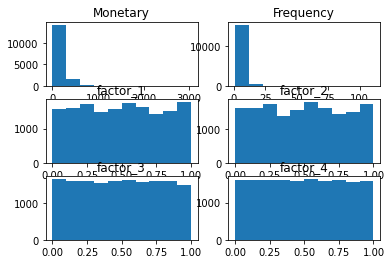

In [3]:
plt.subplot(321)
plt.hist(segment['Monetary'])
plt.title('Monetary')

plt.subplot(322)
plt.hist(segment['Frequency'])
plt.title('Frequency')

plt.subplot(323)
plt.hist(segment['factor_1'])
plt.title('factor_1')

plt.subplot(324)
plt.hist(segment['factor_2'])
plt.title('factor_2')

plt.subplot(325)
plt.hist(segment['factor_3'])
plt.title('factor_3')

plt.subplot(326)
plt.hist(segment['factor_4'])
plt.title('factor_4')

plt.show()

In [4]:
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerId  16000 non-null  object 
 1   Monetary    16000 non-null  float64
 2   Recency     16000 non-null  object 
 3   Frequency   16000 non-null  int64  
 4   factor_1    16000 non-null  float64
 5   factor_2    16000 non-null  float64
 6   factor_3    16000 non-null  float64
 7   factor_4    16000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1000.1+ KB


Просмотрев данные, можно сказать о большом везении, что все данные есть, и не надо ничего заполнять.
Однако надо обработать Recency, т.к. алгоритмы с датами не дружат. Заменяю дату на разницу по сравнению с датой самой последней активности

# Предобработка

In [5]:
segment['Recency'] = pd.to_datetime(segment['Recency'])
latest_day = segment['Recency'].max()
segment['To_last_day_diff'] = pd.Series(map(lambda x: (latest_day - x).days, segment['Recency']))

Предлагаемый PCA избавит от ненужных признаков, однако все равно придется делать визуализацию и т.п., поэтому сразу определю зависимые признаки, чтобы можно было исключить некоторые из них

<AxesSubplot:>

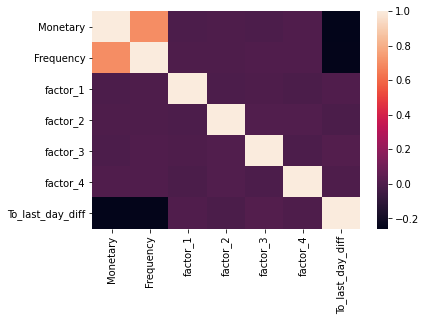

In [6]:
corr = segment.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Monetary и Frequency имеют сильную сависимость (что довольно очевидно). Избавлюсь от Monetary

In [7]:
no_monetary = segment.copy()
no_monetary.drop(['CustomerId','Monetary','Recency'], axis='columns', inplace=True)

Чтобы большие значения не вносили больший вклад в значение функции расстояния, выполним стандартизацию значений (деление на максимальное)

In [8]:
for feature in list(no_monetary):
    max_value = no_monetary[feature].max()
    no_monetary[feature] = list(x/max_value for x in no_monetary[feature])
    
no_monetary.head()

,Frequency,factor_1,factor_2,factor_3,factor_4,To_last_day_diff
0,0.054054,0.35,0.08,0.609742,0.949437,0.072289
1,0.036036,0.66,0.16,0.942276,0.479873,0.132530
2,0.054054,0.92,0.20,0.323032,0.007076,0.132530
3,0.090090,0.35,0.78,0.876836,0.088979,0.530120
4,0.045045,0.51,0.44,0.912103,0.206205,0.403614


# Поиск кластеров. PCA

Теперь, собственно, сам PCA и его результаты

In [9]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(no_monetary.values)
no_monetary['pca-one'] = pca_result[:,0]
no_monetary['pca-two'] = pca_result[:,1] 
no_monetary['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.22063212 0.19786307 0.19441266]


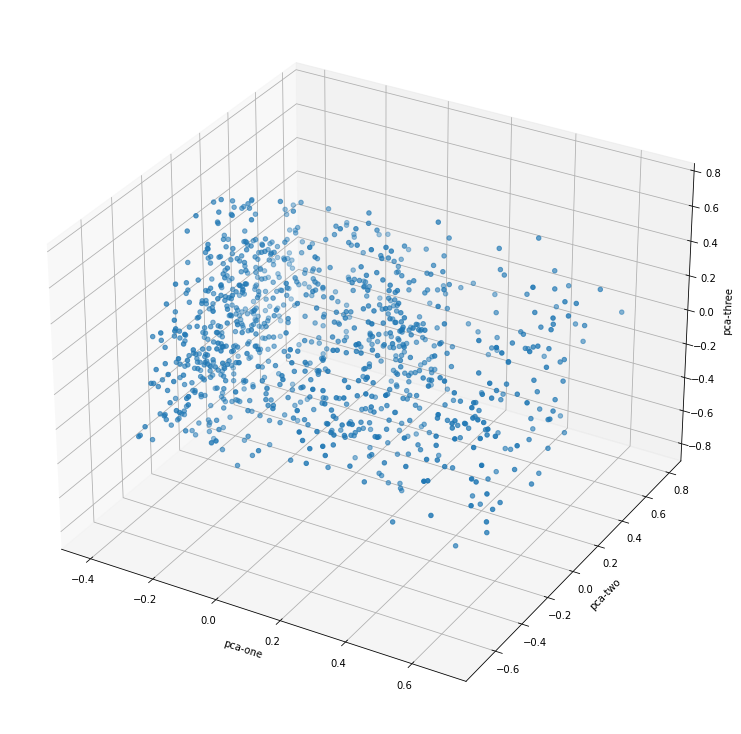

In [10]:
rndperm = list(range(1,1000))

fig = plt.figure(figsize=(16,10))

ax = Axes3D(fig)
 
ax.scatter(
    xs=no_monetary.loc[rndperm,:]["pca-one"], 
    ys=no_monetary.loc[rndperm,:]["pca-two"], 
    zs=no_monetary.loc[rndperm,:]["pca-three"], 
    
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Опредедение кластеров

Попробую сделать 3 и 4 кластера - большее количество групп может запутать

Text(0.5, 1.0, 'Количество кластеров 4')

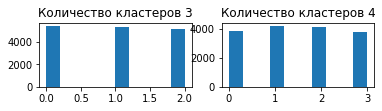

In [11]:
clusters = {}
cluster_data = pd.DataFrame(no_monetary[['pca-one', 'pca-two', 'pca-three']])

for n_clust in [3, 4]:
    kmeans = KMeans(n_clusters=n_clust).fit(cluster_data)
    
    predict = kmeans.predict(cluster_data)
    clusters[n_clust] = predict

plt.subplot(321)
plt.hist(clusters[3])
plt.title('Количество кластеров 3')


plt.subplot(322)
plt.hist(clusters[4])
plt.title('Количество кластеров 4')

В обоих случаях получаются равные группы. Оставлю 3 кластера

In [12]:
n_cluster = 3
cluster_data['cluster'] = clusters[n_cluster]

In [13]:
cluster_data.head()

,pca-one,pca-two,pca-three,cluster
0,-0.254456,-0.027390,-0.374838,1
1,-0.154186,-0.267961,0.165635,1
2,-0.195000,-0.683331,0.185807,1
3,0.190690,0.176319,0.348789,0
4,0.094924,-0.099726,0.267568,2


Теперь можно выполнить визуализацию данных, для чего вернем значения кластеров в сет исходных данных

In [14]:
segment['cluster_1'] = cluster_data['cluster']

In [15]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4,To_last_day_diff,cluster_1
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383,12,1
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846,22,1
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076,22,1
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974,88,0
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194,67,2


Буду использовать двухмерное пространство и попробую определить тройку признаков, которые лучше всего визуализируют кластеры

## Определение значимых признаков и визуализация

/Users/marinahajrtdinova/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/marinahajrtdinova/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/marinahajrtdinova/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

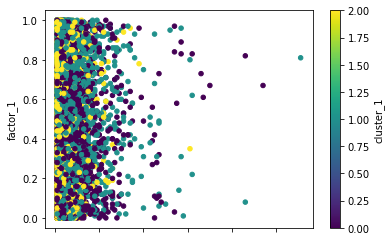

In [17]:
ax2 = segment.plot.scatter(x='Frequency',
                      y='factor_1',
                      c='cluster_1',
                      colormap='viridis')

В данном случае плоскость плохо отражает изменение кластреров, поэтому заменю Frequency на следующий признак - factor_2

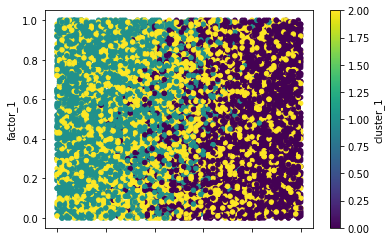

In [18]:
ax2 = segment.plot.scatter(x='factor_2',
                      y='factor_1',
                      c='cluster_1',
                      colormap='viridis')

Теперь можно отделить первый кластер от нулевого. Попробуем эти признаки с factor_3 - возможно получится отделить еще один кластер

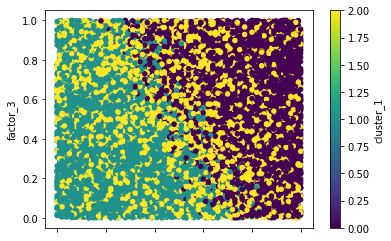

In [19]:
ax2 = segment.plot.scatter(x='factor_2',
                      y='factor_3',
                      c='cluster_1',
                      colormap='viridis')

Желтый кластер по-прежнему плохо различается, однако стало лучше граница между зеленым и красным кластером. Попробуем с этими признаками псоедний оставшийся

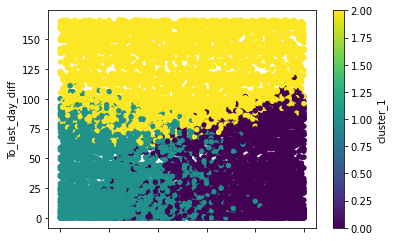

In [20]:
ax2 = segment.plot.scatter(x='factor_2',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

Очень хорошее сечение, попробуем с factor_3

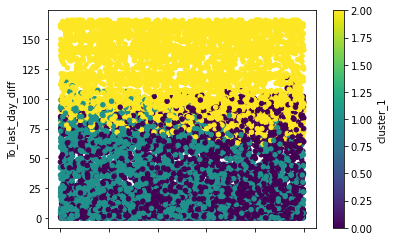

In [21]:
ax2 = segment.plot.scatter(x='factor_3',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

Картина не сильно улучшилась, попробуем вернуть factor_1

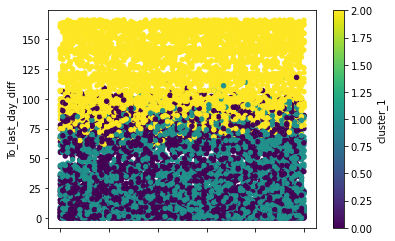

In [22]:
ax2 = segment.plot.scatter(x='factor_1',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

И с Frequency

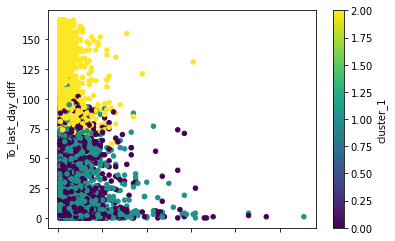

In [23]:
ax2 = segment.plot.scatter(x='Frequency',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

В общем, наилучшее разделение получилось на плоскости factor_2-производный_от_recency. Еще удается определить нечеткую границу на плоскости factor_2-factor_3, где можно отделить красный кластер от зеленого. А желтый выделяется на плоскости factor_2-производный_от_recency. Так что я отдаю предпочтение признакам Recency (после обработки), factor_2 и factor_3

# Поиск кластеров. T-SNE

Теперь попробую другой алгоритм понижения размерности и посмотрим, что получится. Буду использовать все тот же no_monetary, очищенный от результатов работы с PCA

In [24]:
no_monetary = segment.copy()
no_monetary.drop(['CustomerId','Monetary','Recency', 'cluster_1'], axis='columns', inplace=True)

for feature in list(no_monetary):
    max_value = no_monetary[feature].max()
    no_monetary[feature] = list(x/max_value for x in no_monetary[feature])
    
no_monetary.head()


,Frequency,factor_1,factor_2,factor_3,factor_4,To_last_day_diff
0,0.054054,0.35,0.08,0.609742,0.949437,0.072289
1,0.036036,0.66,0.16,0.942276,0.479873,0.132530
2,0.054054,0.92,0.20,0.323032,0.007076,0.132530
3,0.090090,0.35,0.78,0.876836,0.088979,0.530120
4,0.045045,0.51,0.44,0.912103,0.206205,0.403614


In [25]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(no_monetary)
print('Выполнено за {}'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16000 samples in 0.009s...
[t-SNE] Computed neighbors for 16000 samples in 0.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities for sa

In [26]:
no_monetary['tsne-one'] = tsne_results[:,0]
no_monetary['tsne-two'] = tsne_results[:,1] 
no_monetary['tsne-three'] = tsne_results[:,2]

In [27]:
no_monetary.head()

,Frequency,factor_1,factor_2,factor_3,factor_4,To_last_day_diff,tsne-one,tsne-two,tsne-three
0,0.054054,0.35,0.08,0.609742,0.949437,0.072289,1.061555,-0.057805,3.513596
1,0.036036,0.66,0.16,0.942276,0.479873,0.132530,-2.099206,0.814452,1.115713
2,0.054054,0.92,0.20,0.323032,0.007076,0.132530,-5.795690,0.640511,0.573703
3,0.090090,0.35,0.78,0.876836,0.088979,0.530120,2.368805,0.263249,-1.636144
4,0.045045,0.51,0.44,0.912103,0.206205,0.403614,-0.576530,1.056693,-1.271610


## Снова поиск кластеров

Снова сделаю три кластера, чтобы можно было провести сравнение результатов

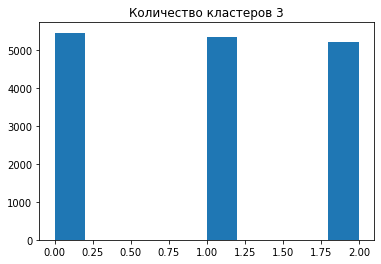

In [28]:
n_cluster = 3
cluster_data = pd.DataFrame(no_monetary[['tsne-one', 'tsne-two', 'tsne-three']])

kmeans = KMeans(n_clusters=n_cluster).fit(cluster_data)
predict = kmeans.predict(cluster_data)

plt.hist(clusters[3])
plt.title('Количество кластеров 3')
plt.show()

In [29]:
segment['cluster_2'] = predict

In [30]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4,To_last_day_diff,cluster_1,cluster_2
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383,12,1,1
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846,22,1,1
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076,22,1,1
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974,88,0,0
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194,67,2,0


## Снова отбор значимых признаков и визуализация 

Посмотрим результаты по тем же измерениям

/Users/marinahajrtdinova/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/marinahajrtdinova/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/marinahajrtdinova/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

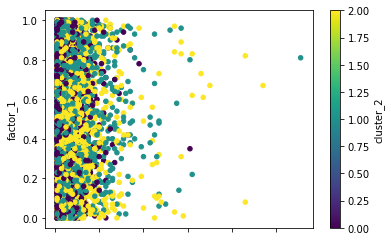

In [31]:
ax2 = segment.plot.scatter(x='Frequency',
                      y='factor_1',
                      c='cluster_2',
                      colormap='viridis')

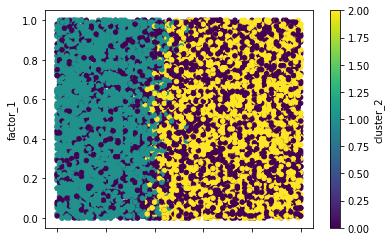

In [34]:
ax2 = segment.plot.scatter(x='factor_2',
                      y='factor_1',
                      c='cluster_2',
                      colormap='viridis')

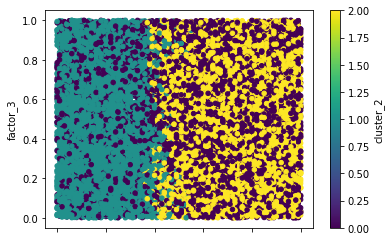

In [35]:
ax2 = segment.plot.scatter(x='factor_2',
                      y='factor_3',
                      c='cluster_2',
                      colormap='viridis')

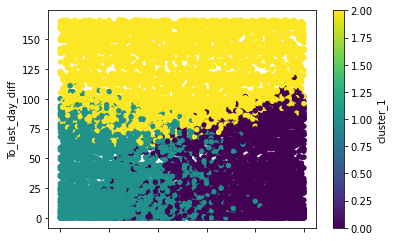

In [36]:
ax2 = segment.plot.scatter(x='factor_2',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

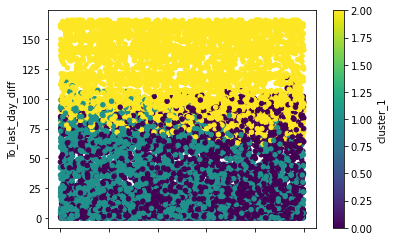

In [37]:
ax2 = segment.plot.scatter(x='factor_3',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

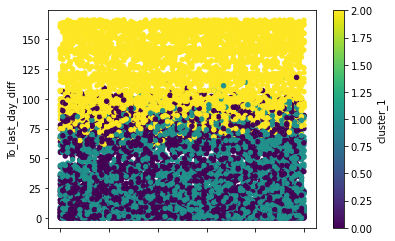

In [38]:
ax2 = segment.plot.scatter(x='factor_1',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

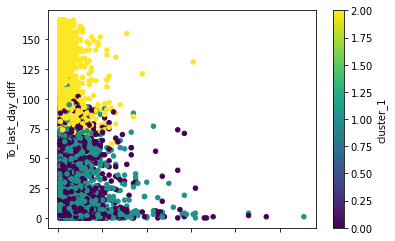

In [39]:
ax2 = segment.plot.scatter(x='Frequency',
                      y='To_last_day_diff',
                      c='cluster_1',
                      colormap='viridis')

Здесь плоскость factor_2-factor_3 не так хорошо справилась, однако factor_2 и recency неплохо делят группы, но все же на мой взгляд удачнее сработал метод PCA

В результате я отдаю однозначное предпочтение recency и factor_2, factor_3 неплохо сработал на PCA